In [1]:
!pip install numpy==1.16.2 # Fix for change in later versions of numpy that causes load_data to fail

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from keras.datasets import imdb

top_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
imdb.get_word_index()

{'speach': 77750,
 "herilhy's": 70670,
 'walgreens': 36414,
 "mcandrew's": 65299,
 'embittered': 14378,
 'heavily': 2696,
 'fairs': 62537,
 'chesapeake': 50233,
 "briggs'": 44485,
 'queensbury': 71387,
 'starlet': 10810,
 'euphues': 75436,
 'liquids': 48502,
 "talking'": 20115,
 "'wounded'": 64735,
 'totin': 62733,
 'famarialy': 81507,
 'perverts': 21226,
 'sexiest': 13534,
 'bolden': 55048,
 'zeitgeist': 19701,
 'starsailor': 78579,
 'adcox': 57750,
 'harrows': 54283,
 "us's": 37542,
 'affair\x85': 67821,
 'justifications': 29702,
 'bookstores': 50437,
 'calvary': 49574,
 'cupertino': 81272,
 'ohs': 56810,
 "mf'ing": 64259,
 'ahn': 41901,
 'heiland': 57650,
 '1886': 47719,
 'humpty': 41442,
 'caress': 27060,
 "pal'": 79880,
 "good'": 11931,
 'sit': 867,
 'passion': 1794,
 'catholicism': 24316,
 "getting'": 65098,
 "'it's": 26027,
 'carbonite': 43707,
 'amitabhs': 88561,
 'lord': 1632,
 'ticking': 14609,
 'carley': 41059,
 'songsmith': 69663,
 'randle': 28106,
 'concieling': 84525,
 "'

In [5]:
word_dict = imdb.get_word_index()
word_dict = { key:(value + 3) for key, value in word_dict.items() }
word_dict[''] = 0  # Padding
word_dict['>'] = 1 # Start
word_dict['?'] = 2 # Unknown word
reverse_word_dict = { value:key for key, value in word_dict.items() }
print(' '.join(reverse_word_dict[id] for id in x_train[0]))

> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [6]:
from keras.preprocessing import sequence 
max_review_length = 500 
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length) 
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2048128   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,368,257
Trainable params: 2,368,257
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=250)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 66s - loss: 0.5966 - acc: 0.6316 - val_loss: 0.3411 - val_acc: 0.8501
Epoch 2/5
25000/25000 [==============================] - 65s - loss: 0.2213 - acc: 0.9114 - val_loss: 0.2856 - val_acc: 0.8801
Epoch 3/5
25000/25000 [==============================] - 66s - loss: 0.0742 - acc: 0.9807 - val_loss: 0.3293 - val_acc: 0.8744
Epoch 4/5
25000/25000 [==============================] - 65s - loss: 0.0191 - acc: 0.9976 - val_loss: 0.3810 - val_acc: 0.8726
Epoch 5/5
25000/25000 [==============================] - 65s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.4170 - val_acc: 0.8726


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


[]

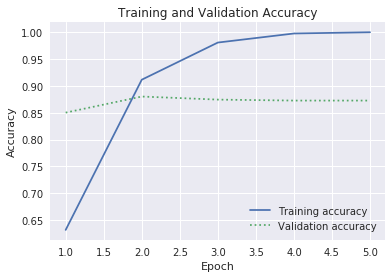

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['acc']
val = hist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [10]:
scores = model.evaluate(x_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 87.26%


In [11]:
import string 
import numpy as np

def analyze(text):
    # Prepare the input by removing punctuation characters, converting
    # characters to lower case, and removing words containing numbers
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.lower().split(' ')
    text = [word for word in text if word.isalpha()]

    # Generate an input tensor
    input = [1]
    for word in text:
        if word in word_dict and word_dict[word] < top_words:
            input.append(word_dict[word])
        else:
            input.append(2)
    padded_input = sequence.pad_sequences([input], maxlen=max_review_length)

    # Invoke the model and return the result
    result = model.predict(np.array([padded_input][0]))[0][0]
    return result

In [12]:
analyze('Easily the most stellar experience I have ever had.')

0.9368466

In [13]:
analyze('The long lines and poor customer service really turned me off.')

0.04482